In [1]:
import torch
from torch.nn import Sequential, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import scipy
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
class FlowMatching(torch.nn.Module):
  def __init__(self, model, forward_model):
    super(FlowMatching, self).__init__()
    print('initializing neural interpolant')
    self.model = model
    self.forward_model = forward_model


  def neural_interpolant(self, x0, x1, t0, t1):
    ## given a set of x0's and x1's determines the linear interpolant between them

    ## get our two path estimation
    xt  = (1-t0) * x0 + t0 * x1 + (1/4 - (0.5 - t0)**2) * self.forward_model(torch.concat([x0, x1], axis = 1), t0.squeeze())
    xtp1  = (1-t1) * x0 + t1 * x1 + (1/4 - (0.5 - t1)**2) * self.forward_model(torch.concat([x0, x1], axis = 1), t1.squeeze())

    ## estimate the gradient
    gr = (xtp1-xt)/(t1-t0)

    return xt, gr

  def sample(x0, num_steps = 100):
      n_steps = 1000

      h = 1.0 / n_steps
      t = 0
      z = x0

      zs = [z]

      for i_step in range(n_steps):
          z = z + h[:, None] * self.model(z, t)
          zs += [z.cpu().detach().numpy()]
          t = t + h
      return zs

  def forward(self, x0, x1):

    t = torch.rand(x0.shape[0]).to('cuda')
    xt, gr = self.neural_interpolant(x0, x1, t[:, None], t[:, None] + 1e-5)
    gr_hat = self.model(xt, t)

    return torch.nn.MSELoss()(gr, gr_hat)


class EmpiricalFlowMatching(FlowMatching):
  def __init__(self, model, forward_model, forward_noise_model):
    super(FlowMatching, self).__init__()
    print('initializing empirical neural interpolant')
    self.model = model
    self.forward_model = forward_model
    self.forward_noise_model = forward_noise_model


  def path_sampling(self, x0, x1, t0, t1, n_steps = 25):
    ## given a set of x0's and x1's determines the linear interpolant between them
    h = (t1-t0) / n_steps
    t = t0
    z = x0

    zs = [z]
    ts = [t]

    for i_step in range(n_steps):
        ## perterb
        z = z + h * (self.forward_model(torch.concat([x0, x1], axis = 1), t.squeeze()) + x1 - x0) \
          + (h**0.5) * torch.rand_like(x0) * self.forward_noise_model(torch.concat([x0, x1], axis = 1), t.squeeze())
        ## used to make z converge to x1
        if t.mean() > 0.7:
          z = z * (1-t) + x1 * t

        t = t + h

        zs += [z]
        ts += [t]

    return zs, ts

  def forward(self, x0, x1):

    B = x0.shape[0]

    t0 = torch.zeros(B).to(x0.device)[:, None]
    t1 = torch.ones(B).to(x1.device)[:, None]

    samples, ts = self.path_sampling(x0, x1, t0, t1)
    ## take gradients
    gr = [(i-j)/(t_end-t_start) for i,j,t_start,t_end in zip(samples[1:], samples[:-1], ts[:-1], ts[1:])]

    gr_hat = [self.model(xt, time.squeeze()) for xt, time in zip(samples[:-1], ts[:-1])] ##

    gr = torch.stack(gr, axis = 0)
    gr_hat = torch.stack(gr_hat, axis = 0)

    return torch.nn.MSELoss()(gr, gr_hat)


In [ ]:
# @title Distribution Utilities
def generate_mixture_gaussians(num_samples=32, centers=6, spread=.5, radius=5.0):
    """
    Generates a mixture of 2D Gaussian distributions around the origin (0,0).

    :param num_samples: Total number of samples to generate.
    :param centers: Number of Gaussian centers.
    :param spread: Standard deviation of each Gaussian.
    :param radius: Radius to space out the Gaussian centers on a circle.
    :return: Tensor of shape (num_samples, 2) containing the Gaussian mixture data.
    """
    data = []
    samples_per_center = num_samples // centers
    remaining_samples = num_samples - samples_per_center * centers

    angles = np.linspace(0, 2 * np.pi, centers, endpoint=False)

    for i, angle in enumerate(angles):

        if i == len(angles) - 1:
            samples_per_center += remaining_samples

        # Calculate center of Gaussian
        center_x = radius * np.cos(angle)
        center_y = radius * np.sin(angle)
        center = np.array([center_x, center_y])

        # Generate samples for a Gaussian
        samples = np.random.normal(loc=center, scale=spread, size=(samples_per_center, 2))
        data.append(samples)

    # Concatenate all samples and shuffle
    data = np.vstack(data)
    np.random.shuffle(data)

    return torch.tensor(data, dtype=torch.float32)


def generate_happy_face(num_samples=32, spread=0.01):
    """
    Generates a dataset shaped like a happy face with clearer features.
    :param num_samples: Total number of samples to generate.
    :param spread: Standard deviation for the Gaussian noise added to the features.
    :return: Tensor of shape (num_samples, 2) containing the happy face data.
    """
    # Create an empty list to hold data points
    data_points = []

    # Face outline - circle
    face_samples = num_samples // 2
    angles = np.linspace(0, 2 * np.pi, face_samples)
    x_face = np.cos(angles)
    y_face = np.sin(angles)
    data_points.extend(zip(x_face, y_face))

    # Eyes - two smaller circles
    eye_samples = num_samples // 20
    eye_radius = 0.1
    angles = np.linspace(0, 2 * np.pi, eye_samples)

    # Left eye
    x_left_eye = -0.35 + eye_radius * np.cos(angles)
    y_left_eye = 0.45 + eye_radius * np.sin(angles)
    data_points.extend(zip(x_left_eye, y_left_eye))

    # Right eye
    x_right_eye = 0.35 + eye_radius * np.cos(angles)
    y_right_eye = 0.45 + eye_radius * np.sin(angles)
    data_points.extend(zip(x_right_eye, y_right_eye))

    # Smile - semi-circle
    smile_samples = num_samples - (face_samples + 2 * eye_samples)
    angles = np.linspace(0.75 * np.pi, 0.25 * np.pi, smile_samples)
    x_smile = -0.85 * np.cos(angles)
    y_smile = -0.85 * np.sin(angles) + 0.35
    data_points.extend(zip(x_smile, y_smile))

    # Convert data_points to numpy array and shuffle
    data = np.array(data_points)
    np.random.shuffle(data)

    # Add Gaussian noise
    data += np.random.normal(scale=spread, size=data.shape)

    return torch.tensor(data*6, dtype=torch.float32)

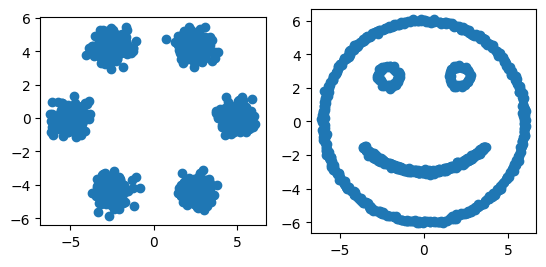

In [ ]:
# @title Test of Distributions
fig, axe = plt.subplots(1,2)

gauss_mixture = generate_mixture_gaussians(num_samples = 1000)
happy_face = generate_happy_face(num_samples = 1000)

axe[0].scatter(gauss_mixture[:,0], gauss_mixture[:,1])
axe[0].set_aspect(1)
axe[1].scatter(happy_face[:,0], happy_face[:,1])
axe[1].set_aspect(1)

In [ ]:
# @title Basic Neural Network
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0]).to(x.device)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size).to(x.device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class PositionalEmbedding(nn.Module):
    def __init__(self, size: int,  **kwargs):
        super().__init__()

        self.layer = SinusoidalEmbedding(size, **kwargs)

    def forward(self, x: torch.Tensor):
        return self.layer(x)

class LearnedEmbedding(nn.Module):
    def __init__(self, input_dim: int, emb_size: int):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_size)

    def forward(self, x: torch.Tensor):
        return self.embedding(x)


class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size)
        self.input_mlp1 = PositionalEmbedding(emb_size, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)

        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

In [ ]:
# @title Basic Test of Flow Matching with Small Neural Network

device = 'cuda'

model = MLP().to(device)
forward_model = MLP().to(device)
forward_noise_model = MLP().to(device)
pipeline = EmpiricalFlowMatching(model, forward_model, forward_noise_model).to(device)

optimizer = torch.optim.Adam( [*model.parameters(), *forward_model.parameters(), *forward_noise_model.parameters()], lr = 3e-3)

losses = []

steps = 10000

schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

for i in range(steps):

  x0 = generate_mixture_gaussians(num_samples = 512).to(device)
  x1 = generate_happy_face(num_samples = 512).to(device)

  loss = pipeline(x0, x1)

  losses += [loss.item()]

  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  schedule.step()

plt.plot(losses)


Streaming output truncated to the last 5000 lines.
x shape: torch.Size([512, 4])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 4])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 4])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 4])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 4])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size([512, 2])
t embed: torch.Size([512, 128])
x shape: torch.Size

KeyboardInterrupt: 

In [ ]:
losses[-1]

IndexError: list index out of range

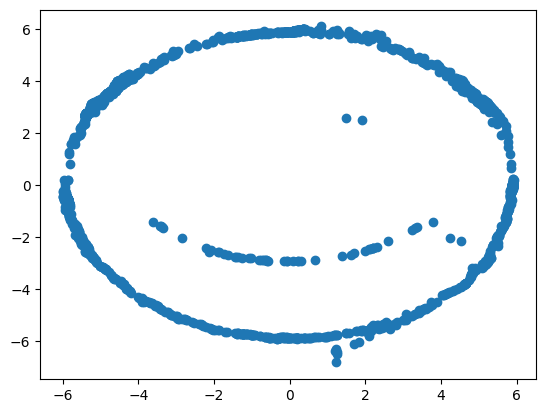

In [ ]:
import math

def ode_solve(z0, t0, t1, f):
    n_steps = 1000

    h = (t1 - t0) / n_steps
    t = t0
    z = z0

    zs = []

    for i_step in range(n_steps):
        z = z + h[:, None] * f(z, t)
        zs += [z.cpu().detach().numpy()]
        t = t + h

    return zs

with torch.no_grad():
  x0 = generate_mixture_gaussians(num_samples = 2000).to(device)
  t0 = torch.zeros_like(x0)[:,0].to(device)
  t1 = torch.ones_like(x0)[:,0].to(device)
  approx = ode_solve(x0, t0, t1, model)

plt.scatter(approx[-1][:,0], approx[-1][:,1])

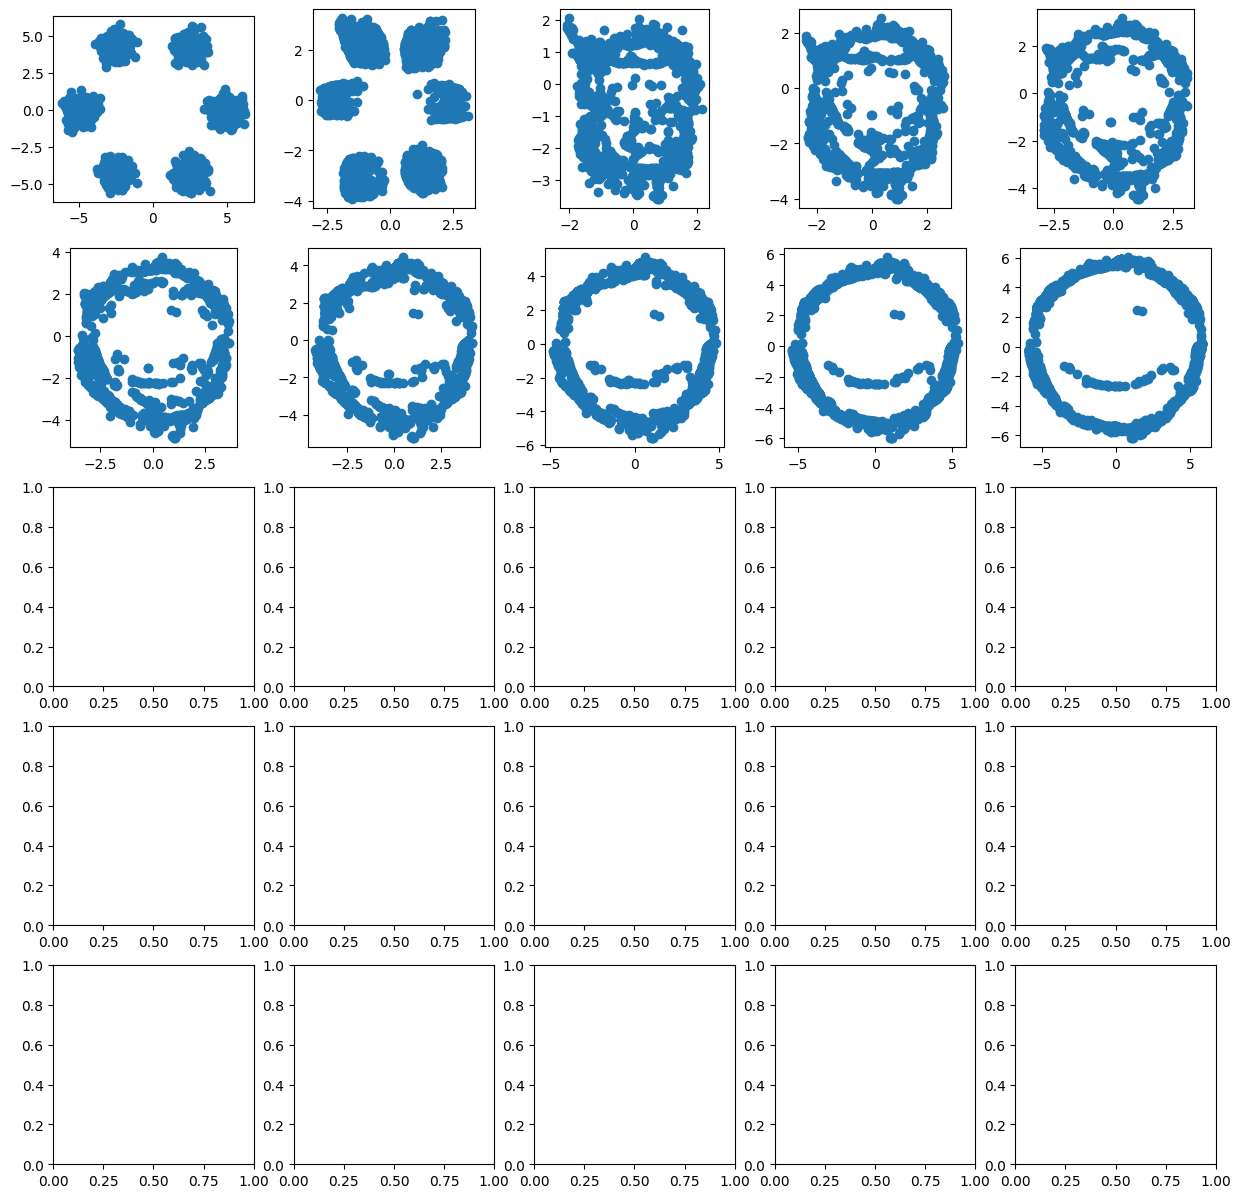

In [ ]:
fig, axe = plt.subplots(5, 5, figsize=(15, 15))

j = 0

for i in range(1, 1000, 100):
  axe[j // 5, j % 5].scatter(approx[i][:,0], approx[i][:,1])
  axe[j // 5, j % 5].set_aspect(1)
  j+=1

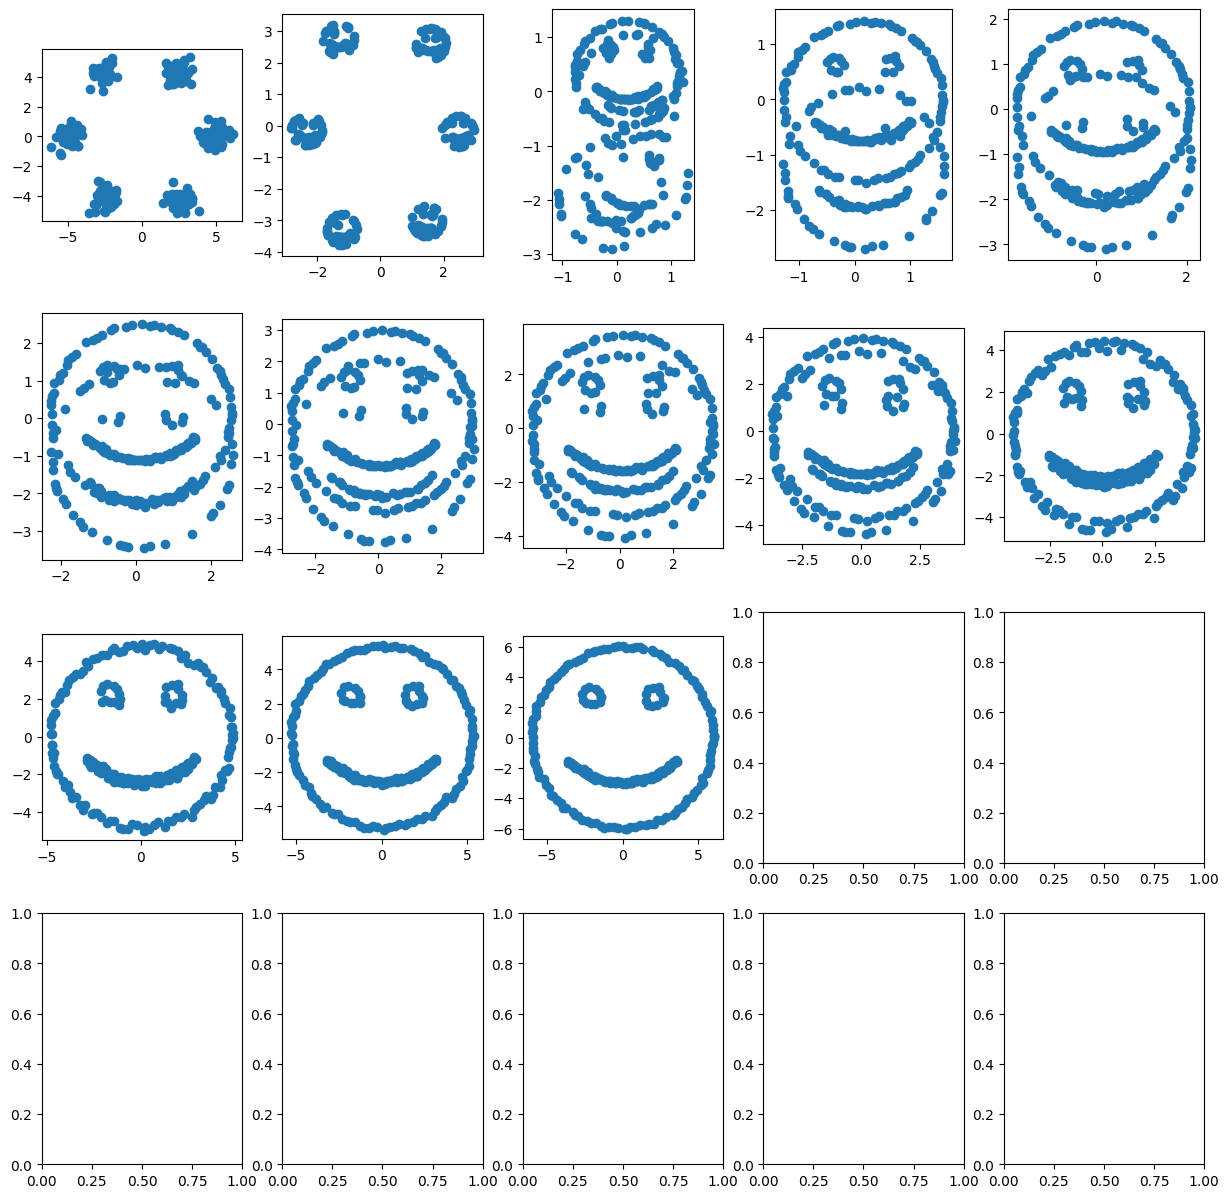

In [ ]:
B= 250

x0 = generate_mixture_gaussians(num_samples = 250).to(device)
x1 = generate_happy_face(num_samples = 250).to(device)

t0 = torch.zeros(B).to(x0.device)[:, None]
t1 = torch.ones(B).to(x1.device)[:, None]

with torch.no_grad():
  approx = pipeline.path_sampling(x0, x1, t0, t1)[0]
fig, axe = plt.subplots(4, 5, figsize=(15, 15))

j = 0

for i in range(0, 25, 2):
  axe[j // 5, j % 5].scatter(approx[i][:,0].detach().cpu(), approx[i][:,1].detach().cpu())
  axe[j // 5, j % 5].set_aspect(1)
  j+=1

In [ ]:
torch.save([model.state_dict(), forward_model.state_dict(), forward_noise_model.state_dict()], "SDE Model First")

In [ ]:
(forward_model(torch.concat([x0, x1], axis = 1), t.squeeze()) - (x1-x0))**2

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 512 for tensor number 2 in the list.

# RL Env

In [15]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding


from torchvision.datasets import MNIST, CIFAR10
from typing import *
import numpy as np

In [9]:
# mnist_dataset = MNIST(root="./data/")
# cifar10_dataset = CIFAR10(root="./data/")
class SmileyFaceDataset(torch.utils.data.Dataset):
    def __init__(self, size:int=100, transform=None):
        self.data = [generate_happy_face(num_samples = 1000) for i in range(size)]
        for i in range(size):
            img = generate_happy_face(num_samples=1000)
            if transform:
                img = transform(img)
            self.data.append(img)

    def __getitem__(self, index):
        return self.data[index]

In [13]:
import torch.utils as utils
from torchvision.transforms import v2


class FlowDiffusionGym(gym.Env):
    def __init__(
        self,
        dataset: str,
        obs_horizon: Tuple[float], 
        obs_shape: Tuple[float], 
        action_range: Tuple[float], 
        action_shape: Tuple[float],
        max_time_step: int, 
        batch_size=256
    ) -> None:
        super(FlowDiffusionGym, self).__init__()
        transform = v2.Compose([v2.ToTensor()])
        if dataset not in {"MNIST", "CIFAR10", "smily_face"}:
            raise Exception("OOF, INVALID DATASET")
        elif dataset == "smiley_face":
            self.dataset = SmileyFaceDataset(transform=transform)
        else:
            self.dataset = eval(f"torchvision.datasets.{dataset}(root='./data/', transform=transform)")
        self.observation_space = spaces.Box(*obs_horizon, obs_shape)
        self.action_space = spaces.Box(*action_range, action_shape)
        self.batch_size = batch_size
        self.time = 0
        self.max_time_step = max_time_step
        
        # current images
        self.cur_state = None
        # all images in the trajectory
        self.states = []
        # action log probabilities for the trajectory
        self.action_log_probs = []
        # rewards for the trajectory
        self.rewards = []
        # termination for the trajectory
        self.is_terminated = []
        
        self.img_idxs = []
        
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    @torch.no_grad()
    def step(self, action: torch.Tensor, value_net: nn.Module):
        """
        Args:
            action [torch.Tensor]: same dimension with image space, predict the movement of the image
            value_net [nn.Module]: value network for estimating MSE Loss with forward learned vector field network
        """
        is_terminated = False
        is_truncated = False
        info = dict()

        
        is_terminated = self._is_terminated()
        is_truncated = self._is_truncated()
        return observation, reward, is_terminated, is_truncated, info

    def reset(self, seed=None, options=None):
        self.img_idxs = torch.randperm(self.dataset.shape[0])[:self.batch_size]
        self.states = self.dataset[self.img_idxs]
        self.time = 0
        return dict()

    def render(self, *args, **kwargs):
        pass

    def close(self):
        # Don't really need to worry about this
        pass

    def _calculate_reward(self, ):
        pass
    
    def _is_terminated(self):
        return torch.mean((self.cur_state - self.dataset[self.img_idxs])**2) < 0.01
    
    def _is_truncated(self):
        return self.time >= self.max_time_step